# Analyse quantitative multibranche

In [13]:
from traitlets.config.loader import load_pyconfig_files
config = get_ipython().config
config['ProfileDir']['location']

In [3]:
from jupyter_core.paths import jupyter_path
print(jupyter_path('nbconvert','templates'))

['C:\\Users\\pmasse\\AppData\\Roaming\\jupyter\\nbconvert\\templates', 'C:\\Users\\pmasse\\AppData\\Local\\Continuum\\anaconda3\\envs\\py3\\share\\jupyter\\nbconvert\\templates', 'C:\\ProgramData\\jupyter\\nbconvert\\templates']


In [2]:
import pandas as pd
pd.options.display.width=108
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_venn import venn3_unweighted, venn3

On charge les données d'un fichier exporté du système de gestion des branches RHD.

In [3]:
path = Path('..') / 'data' / 'export2020.csv'

types = {
    'material': 'object', 
    'branch': 'int',
    'plant': 'object',     
    'type': 'object',
    'designation': 'object',
    'del_mand': 'bool', 
    'del_plant': 'bool',
    'march_group': 'object', 
    'storage_cond': 'object',
    'hier': 'object',
}
df = pd.read_csv(path,
                 sep=';',
                 encoding='latin-1',
                 engine='python',
                 header=0,
                 skipfooter=1, # footer line with totals in export
                 dtype=types,
                 true_values=['X'], # for del_mand and del_plant
                 false_values=['', np.nan], # for del_mand and del_plant
                )
df = df[types.keys()] #filter and reorder columns

Parmi les colonnes conservées, on a : 
- le code article (material)

- le code de branche de création (branch).
    - 1: PassionFroid
    - 2: EpiSaveurs
    - 3: TerreAzur

- le code d'activation sur une branche (plant).
    - 1PPF: PassionFroid
    - 2PES: EpiSaveurs
    - 3PTA: TerreAzur

- le type d'article (type). Seuls ZNEG et ZPRE représententent des aricles de marchandises.
    - ZNEG: Négoce
    - ZPRE: Prestation
    - ZENG: Article d'engagement (fictif pour facturation)
    - ZEMB: Article d'emballage (ex: palette)
    - ZSER: Article de service 
- le libellé de l'article (designation)
- si l'article est marqué pour suppression pour toutes les branches (del_mand)
- si l'article est marqué pour suppression sur la branche mentionnée dans la colonne plant (del_plant).
- le groupe de marchandises (march_group) :
    - ZSURGE: Surgelés
    - ZFRAIS: Frais (PassionFroid)
    - ZEPI: Epicerie
    - ZBOI: Boissons
    - ZHYG: Hygiène et chimie
    - ZFLF: Fruits et légumes (TerreAzur)
    - ZFP: Fleurs et plantes
    - ZELAB: Produits élaborés (TerreAzur)
- la condition de stockage (storage_cond) :
    - FR: Frais (PassionFroid)
    - SU: Surgelé,
    - EP: Epicerie,
    - AL: Alcool
    - HY: Hygiène et chimie
    - FL: Fruits et légumes (TerreAzur)
    - FP: Fleurs et plantes
    - MA: Marée
    - SA: Saurisserie (produits élaborés de la mer)
    - SE: Articles de Service
    - PL: Articles de publicité
- la hiérarchie produit (hier). Un plan de classement sur 6 niveaux, représentés par 2 caractères numériques chacun.

In [4]:
df.loc[[5000, 90000, 100000, 130000, 110000] , :]

,material,branch,plant,type,designation,del_mand,del_plant,march_group,storage_cond,hier
5000,15712,2,2PES,ZNEG,PSVNX CERN BRISURE S/AZ SAC 1KGX12 CERNO,True,True,ZEPI,EP,832020500505
90000,153086,3,3PTA,ZNEG,MANGUE KENT 351/550G PAD 12F DELIC BR°,False,False,ZFLF,FL,920518010405
100000,165387,1,1PPF,ZNEG,SALADE PLT 1KGX12 HAMAL,False,False,ZFRAIS,FR,202520150505
130000,203582,1,1PPF,ZPRE,EFFILOCHE BOEUF BARBACOA (2KGX6)/12KG CS,False,False,ZSURGE,SU,401015051505
110000,177238,2,2PES,ZNEG,COMP POIRE ALL BIO BTE 5/1X3 STM,False,False,ZEPI,EP,832005451505


On peut calculer la volumétrie d'articles et la représenter comme un histogramme :

In [5]:
counts = df.groupby('plant')['material'].count().rename('Total')
filtered_counts = df[~df.del_mand & ~df.del_plant].groupby('plant')['material'].count().rename('Actifs')
report = pd.concat([counts, filtered_counts], axis=1)
report.loc['Délice et Création', :] = [10000, 10000]
report.loc['Saveurs d\'Antoine', :] = [12000, 12000]
report.rename({'1PPF': 'PassionFroid', 
               '2PES': 'EpiSaveurs',
               '3PTA': 'TerreAzur'}, 
              inplace=True)
report

,Total,Actifs
plant,,
PassionFroid,48478.0,24898.0
EpiSaveurs,22498.0,12798.0
TerreAzur,73804.0,62789.0
Délice et Création,10000.0,10000.0
Saveurs d'Antoine,12000.0,12000.0


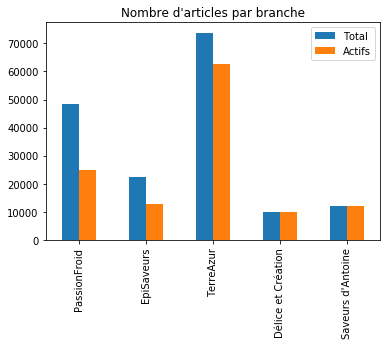

In [6]:
fig, ax = plt.subplots()
report.plot(kind='bar', ax=ax)
ax.set_title('Nombre d\'articles par branche')
ax.set_xlabel('')
fig.savefig(Path('..') / 'img' / 'Articles par branche.png', bbox_inches='tight')

On peut également contruire le diagramme de Venn des articles pour les branches RHD :

In [7]:
branch_sets = [set(df.loc[df.plant == branch_, 'material']) for branch_ in ['1PPF', '2PES', '3PTA']]
filtered_df = df.loc[~df.del_mand & ~df.del_plant]
filtered_sets = [set(filtered_df.loc[filtered_df.plant == branch_, 'material']) for branch_ in ['1PPF', '2PES', '3PTA']]
filtered_march_df = filtered_df.loc[filtered_df.type.isin(['ZNEG', 'ZPRE'])]
filtered_march_sets = [set(filtered_march_df.loc[filtered_march_df.plant == branch_, 'material'])
                       for branch_ in ['1PPF', '2PES', '3PTA']] 

In [8]:
def labelize(ax, label, where='bottom', **kwargs):
    ax.set_axis_on()
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)
        if where == 'bottom':
            ax.set_xlabel(label, **kwargs)
        elif where == 'left':
            ax.set_ylabel(label, **kwargs)
        else:
            raise ValueError(f"Unexpected 'where' argument: {where}")

row:  0
col:  0
x: (-0.6844274558714712, 0.612390707014605)
y: (-0.7254296963520378, 0.625958466798942)
----------------------------
col:  1
x: (-0.6176413774278168, 0.6158068974651963)
y: (-0.7254296963520378, 0.7259584667989419)
----------------------------
col:  2
x: (-1.0751986943429097, 0.8641151155360565)
y: (-0.7254296963520378, 0.7259584667989419)
----------------------------
row:  1
col:  0
x: (-1.0751986943429097, 0.8641151155360565)
y: (-0.5538818125384534, 0.5538818125384534)
----------------------------
col:  1
x: (-1.0751986943429097, 0.8641151155360565)
y: (-0.7254296963520378, 0.7259584667989419)
----------------------------
col:  2
x: (-1.0751986943429097, 0.8641151155360565)
y: (-0.7254296963520378, 0.7259584667989419)
----------------------------
(-1.0751986943429097, 0.8641151155360565)


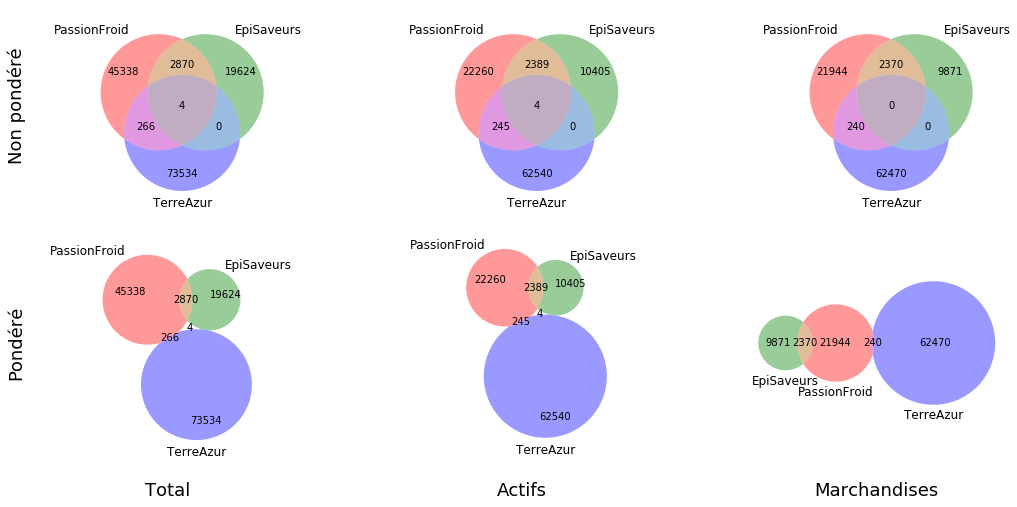

In [9]:
scope = ['Total', 'Actifs', 'Marchandises']
types = ['Non pondéré', 'Pondéré']
nrows, ncols = len(types), len(scope)

fig, axs = plt.subplots(nrows, ncols, sharex='col', sharey='row', figsize=(18, 8))

for col, source_df in enumerate([branch_sets, filtered_sets, filtered_march_sets]):
    for row, venn_kind in enumerate([venn3_unweighted, venn3]):        
        venn_kind(source_df, set_labels=['PassionFroid', 'EpiSaveurs', 'TerreAzur'], ax=axs[row, col])
        if col == 0: 
            labelize(axs[row, col], types[row], where='left', fontsize=18, labelpad=10)
        if row == 1: 
            labelize(axs[row, col], scope[col], where='bottom', fontsize=18, labelpad=40)

xmin = min([axs[row][col].get_xlim()[0] for row in range(nrows) for col in range(ncols)])
xmax = max([axs[row][col].get_xlim()[1] for row in range(nrows) for col in range(ncols)])
ymin = min([axs[row][col].get_ylim()[0] for row in range(nrows) for col in range(ncols)])
ymax = max([axs[row][col].get_ylim()[1] for row in range(nrows) for col in range(ncols)]) + 0.1

for row in range(nrows):
    print('row: ', row)
    for col in range(ncols):
        print('col: ', col)
        print('x:', axs[row, col].get_xlim())
        print('y:', axs[row, col].get_ylim())
        print('----------------------------')
        axs[row, col].set_xlim(xmin, xmax)
        axs[row, col].set_ylim(ymin, ymax)

print(axs[0, 0].get_xlim())
        
fig.savefig(Path('..') / 'img' / 'Diagrammes de Venn articles.png', bbox_inches='tight')


In [10]:
df[df.material.isin(df.material.value_counts()[df.material.value_counts() >= 3].index)]

,material,branch,plant,type,designation,del_mand,del_plant,march_group,storage_cond,hier
144564,DECOMPTE,1,2PES,ZSER,ARTICLE DE DECOMPTE CONDITIONS ARRIERES,False,False,ZAUTRE,NaN,900505050505
144565,DECOMPTE,1,3PTA,ZSER,ARTICLE DE DECOMPTE CONDITIONS ARRIERES,False,False,ZAUTRE,NaN,900505050505
144566,DECOMPTE,1,1PPF,ZSER,ARTICLE DE DECOMPTE CONDITIONS ARRIERES,False,False,ZAUTRE,NaN,900505050505
144612,FC41849,1,1PPF,ZSER,RÉGUL SURFACTURATION DÉCONDITIONNEMENT,False,False,ZAUTRE,NaN,900505050505
144613,FC41849,1,2PES,ZSER,RÉGUL SURFACTURATION DÉCONDITIONNEMENT,False,False,ZAUTRE,NaN,900505050505
144614,FC41849,1,3PTA,ZSER,RÉGUL SURFACTURATION DÉCONDITIONNEMENT,False,False,ZAUTRE,NaN,900505050505
144642,LOT_ENGT,1,1PPF,ZENG,LOT ENGAGEMENT,False,False,NaN,NaN,NaN
144643,LOT_ENGT,1,3PTA,ZENG,LOT ENGAGEMENT,False,False,NaN,NaN,NaN
144644,LOT_ENGT,1,2PES,ZENG,LOT ENGAGEMENT,False,False,NaN,NaN,NaN
144719,S_PALETTE_PERDUE,3,3PTA,ZEMB,PALETTE 80X120 PERDUE,False,False,ZAUTRE,NaN,700510050505


In [11]:
print(', '.join(map(str, range(50))))

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49
